# Postsecondary School Enrollment Forecast (State Level)

NCES publishes its school enrollment data every year here: https://nces.ed.gov/ipeds/datacenter/

However, the latest you data can find is always 1 year behind, in order to get the latest estimate, below shows my implementation using ARIMA to forecast current and next year's enrollment number.

NCES has forecast on national level and few demographic attribute, however, there's no state level forecast.

## 1. Aggregate College Enrollment by State

In [3]:
# load package
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from statsmodels import api as sm
import numpy as np

# turn off warning
import warnings
warnings.filterwarnings('ignore')

# load data
enrollment = pd.read_excel('DATA_SOURCE\ENROLLMENT_FORECAST_DS.xlsx', sheetname='EnrollmentByInstitution')
inst_state = pd.read_excel('DATA_SOURCE\ENROLLMENT_FORECAST_DS.xlsx', sheetname='Institution')
inst_state.columns = ['UnitId', 'Name', 'City', 'State']
state_enrollment = enrollment.merge(inst_state.drop('Name', axis = 1))
# a preview
state_enrollment.head(2)

,UnitId,Institution Name,Fall 1990,Fall 1991,Fall 1992,Fall 1993,Fall 1994,Fall 1995,Fall 1996,Fall 1997,...,Fall 2007,Fall 2008,Fall 2009,Fall 2010,Fall 2011,Fall 2012,Fall 2013,Fall 2014,City,State
0,100654,Alabama A & M University,4886,5215,5068,5593,5543,5400,5263,5094,...,5706,5124,5327,5814,4922,4853,5020,5333,Normal,AL
1,100663,University of Alabama at Birmingham,15356,15922,15735,15913,15362,15502,15274,14933,...,16246,16149,16874,17543,17575,17999,18568,18698,Birmingham,AL


Transpose the dataframe, use state as column and convert to dateindex

In [5]:
# some plastic surgery on the df
# group sum by state
to_group = state_enrollment.drop(['UnitId', 'Institution Name', 'City'], axis = 1)
to_group = to_group.replace('-', 0)
state_enrollment_grp = to_group.groupby('State')
df = state_enrollment_grp.agg(sum).reset_index()

df = df.transpose()
# columns as state
df.columns = df.ix[0,:].values
df = df.drop(['State'])
# add time series index
df.index = [pd.Period(x, freq = 'A') for x in range(1990,2015)]
df.head()

,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
1990,30471,202277,97916,1219,268870,1802163,236702,163844,78584,40180,...,220675,884868,124178,352131,1684,35610,279222,299033,84479,31326
1991,30970,207636,100888,1267,273808,2022436,244078,161175,76601,40918,...,230808,899967,133599,356193,1797,36529,282195,308598,86612,32118
1992,30711,213071,105410,1295,279539,1988820,250938,161887,80484,41428,...,237241,919743,134758,353280,1856,36492,284064,306921,88558,31548
1993,30759,218898,107596,1264,282396,1902889,252174,167481,80843,43768,...,240956,931777,144934,348538,1867,35645,305594,308477,88720,30738
1994,28654,215188,105610,1249,289100,1878425,251173,166098,75823,44403,...,239474,945499,151231,354617,1915,34785,309511,303697,86129,30730


## 2. Prepare the Model

* **Timeseries Model: ARIMA - [Details on ARIMA](http://people.duke.edu/~rnau/411arim.htm)**

* **Error Metrics: MAPE - [Details on MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)**

In [6]:
def produce_forecast(hold_out_n, inog, order, exog = None):
    """
    CV module
    input: 
    hold_out_n (hold out n years from training for cross validation)
    inog: endogenous variable (the enrollment number to forecast)
    exog: exogenous variable (other variable to forecast, if any)
    order: (p, d, q) parameter of ARIMA model
    output:
    print (average MAPE across all states)
    mape by state
    """
    
    def forecast_state(inog, exog, order, hold_out_n):
        # prep exog
        if exog is not None:
            train_exog = exog[:-hold_out_n]
            hold_out_exog = exog[-hold_out_n:]
        else:
            train_exog = hold_out_exog = None
        
        # forecast wrapper
        m = sm.tsa.ARIMA(inog, order=order, exog=train_exog)
        model = m.fit()
        
        return model.forecast(hold_out_n, exog = hold_out_exog, alpha = .95)[0]
    
    forecast_y = []
    
    # data needed
    Y = inog.ix[:-hold_out_n,]
    yTrue = inog.ix[-hold_out_n:,]
    
    if exog is not None:
        X = exog
    else:
        X = None
    
    for state in Y.columns:
        stateY = Y[state]
        yHat = forecast_state(stateY.values.astype('float64'), X, order, hold_out_n)
        forecast_y.append(yHat)
    
    test = yTrue
    yHat = np.array(forecast_y).transpose()
    error_matrix = abs(yTrue-yHat)/yHat
    
    print('MAPE for ARIMA %i, %i, %i' % order)
    print((np.sum(error_matrix, axis = 1)/Y.shape[1]))
    
    plt.figure(figsize = (15,3))
    plt.title('mape');
    plt.plot(error_matrix.ix[0], '-o');
    plt.plot(error_matrix.ix[1], '-o');
    plt.xticks(range(Y.shape[1]), df.columns, rotation = 'vertical');
    plt.legend(error_matrix.index)
    return error_matrix

MAPE for ARIMA 1, 0, 0
2013    0.023323
2014    0.039384
Freq: A-DEC, dtype: float64


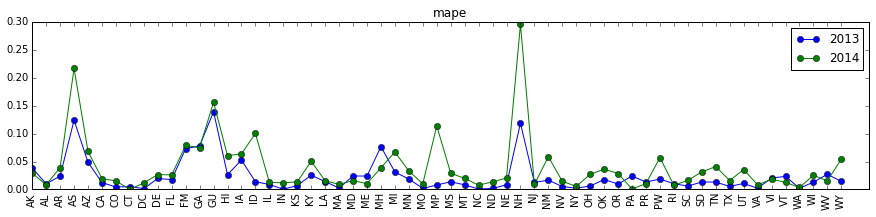

In [7]:
error_100 = produce_forecast(2, df, (1,0,0), exog = None)

Looks good!
## 3. Add National Umemployment Rate as Exog

In [8]:
# load umemployment data
umemployment = pd.read_excel('DATA_SOURCE\ENROLLMENT_FORECAST_DS.xlsx', sheetname='Unemployment Rate')
umemployment.index = [pd.Period(x, freq = 'A') for x in umemployment.Year]
umemployment.drop(['Year'], axis = 1, inplace=True)

MAPE for ARIMA 1, 0, 0
2013    0.022335
2014    0.038261
Freq: A-DEC, dtype: float64


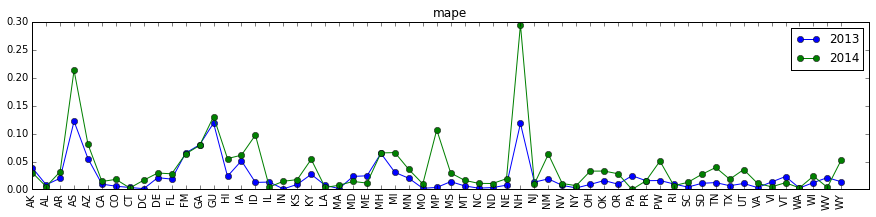

In [11]:
# umemployment lag 1
error_100_ue1 = produce_forecast(2, df, (1,0,0), exog = umemployment.ix[33:-1,0])

MAPE for ARIMA 1, 0, 0
2013    0.020552
2014    0.035016
Freq: A-DEC, dtype: float64


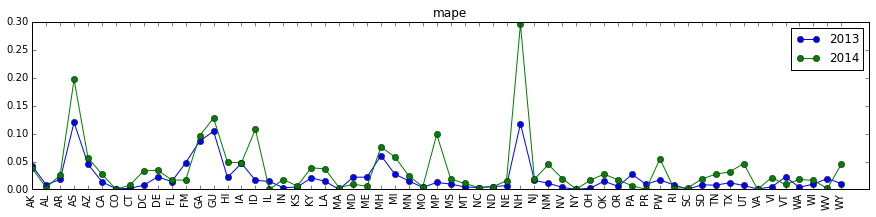

In [13]:
# umemployment lag 0 + lag 1
error_100_ue01 = produce_forecast(2, df, (1,0,0), exog = np.vstack([umemployment.ix[33:-1,0], umemployment.ix[34:,0]]).transpose())

Slight improvement.

## 4. Add Disposable Income as Exog

In [14]:
# load disposable income data
dp = pd.read_excel('DATA_SOURCE\ENROLLMENT_FORECAST_DS.xlsx', sheetname='DISPOSABLE_INCOME')
dp.columns = ['Year', 'DSPI']
dpg = dp.groupby('Year')
dp = dpg.mean().reset_index()
dp.index = [pd.Period(x, freq = 'A') for x in dp.Year]
dp.drop(['Year'], axis = 1, inplace=True)

MAPE for ARIMA 1, 0, 0
2013    0.028857
2014    0.056395
Freq: A-DEC, dtype: float64


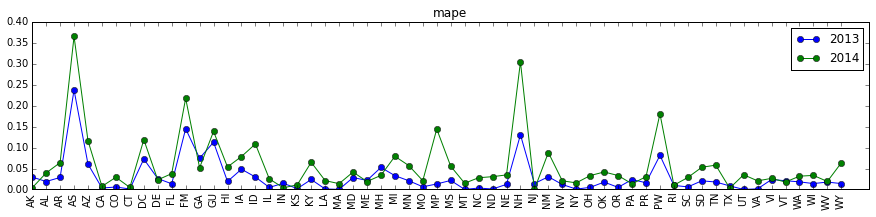

In [17]:
# umemployment lag 0 + lag 1 + lag 5 disposable income
# not helping, but lag 5 has the lowest avg mape
exog = np.vstack([umemployment.ix[33:-1,0], umemployment.ix[34:,0], dp.ix[27:-5,0]]).transpose()
error_100_ue01 = produce_forecast(2, df, (1,0,0), exog = exog)

# Write Forecast File

In [18]:
# 2015/6's umpmployment rate forecast from fed = [5.0, 4.8]
# http://www.federalreserve.gov/monetarypolicy/files/fomcprojtabl20150917.pdf

umemployment.ix[pd.Period(2015, freq = 'A')] = 5.0
umemployment.ix[pd.Period(2016, freq = 'A')] = 4.8

exog = np.vstack([umemployment.ix[34:,0], umemployment.ix[33:-1,0]]).transpose()
order = (1,0,0)
forecast_y = []

for state in df.columns:
    stateY = df[state]
#     yHat = forecast_state(stateY.values.astype('float64'), X, order, hold_out_n)
    m = sm.tsa.ARIMA(stateY.values.astype('float64'), order=order, exog=exog[:-2])
    model = m.fit()
    yHat = model.forecast(2, exog = exog[-2:], alpha = .95)[0]
    forecast_y.append(yHat)

In [19]:
output = pd.DataFrame(forecast_y)
output = output.transpose()
output.columns = df.columns
output.index = [pd.Period(2015, freq = 'A'), pd.Period(2016, freq = 'A')]
pd.concat([df, output]).transpose().head()
# pd.concat([df, output]).transpose().to_csv('output.csv')

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
AK,30471,30970,30711,30759,28654,29484,28758,28185,27811,27446,...,31524,31813,33674,34974,35572,33859,34890,34331,34174.6,34098.4
AL,202277,207636,213071,218898,215188,213244,209603,207582,207054,214385,...,269365,312618,314383,328947,320590,312102,307496,306600,303406,301607
AR,97916,100888,105410,107596,105610,106284,109092,113609,117069,119083,...,155393,161652,172056,180365,184173,181259,176924,174173,172296,171204
AS,1219,1267,1295,1264,1249,1232,1239,1248,909,1172,...,1767,1806,2189,2193,2091,1795,1488,1276,1271.97,1280.21
AZ,268870,273808,279539,282396,289100,287673,293032,296582,307991,324855,...,634693,716185,844548,804301,807995,746342,704905,685630,671578,665477
